In [1]:
%load_ext autoreload
%autoreload 2

import ml_utils
import numpy as np
import pickle as pkl
from tqdm import tqdm
import sklearn
import matplotlib.pyplot as plt
import gzip
import pickle as pkl

In [2]:
with gzip.open("data.pkl.gz", "rb") as f:   data = pkl.load(f)

features: dict[int: dict[str: float]] = data["features"]
time_series: dict[int: dict[str: list[float]]] = data["time_series"]

pIDs: list[int] = list(features.keys())

merged: dict[int: dict[str: float | list[float]]] = {pID: {**features[pID], **time_series[pID]} for pID in pIDs}

In [3]:
X: list[np.ndarray[float]] = []
Y: list[np.ndarray[float]] = []

for t in tqdm(range(len(merged[8405]["IC"]))):

    Xt: list[np.ndarray[float]] = []
    Yt: list[np.ndarray[float]] = []

    for pID in pIDs:

        xt, yt = ml_utils.vectorize_with_nan(merged[pID], t)

        Xt.append(xt)
        Yt.append(yt)
    
    Xt: np.ndarray[float] = np.concatenate(Xt, axis=0)[None, ...]
    Yt: np.ndarray[float] = np.concatenate(Yt, axis=0)[None, ...]

    X.append(Xt)
    Y.append(Yt)

X: np.ndarray[float] = np.concatenate(X, axis=0)
Y: np.ndarray[float] = np.concatenate(Y, axis=0)

100%|██████████| 8588/8588 [02:12<00:00, 64.77it/s]


In [4]:
h: int = 20

Xh: np.ndarray[float] = ml_utils.horizon(X, Y, h)

T, N, D = Xh.shape

In [5]:
S: int = 20
X_train, X_test, Y_train, Y_test = ml_utils.split_by_individuals(Xh, Y, test_size=S)
Y_train, Y_test = Y_train.reshape(-1,), Y_test.reshape(T, -1)

In [ ]:
model = sklearn.pipeline.Pipeline([
    ("imputer", ml_utils.MedianImputer3D(strategy="global")),
    ("flatten", ml_utils.Flatten3D()),
    ("reg", sklearn.ensemble.RandomForestRegressor())
])

model.fit(X_train, Y_train)

In [189]:
Y_pred_train = model.predict(X_train).reshape(T, -1)
Y_pred_test = model.predict(X_test).reshape(T, -1)

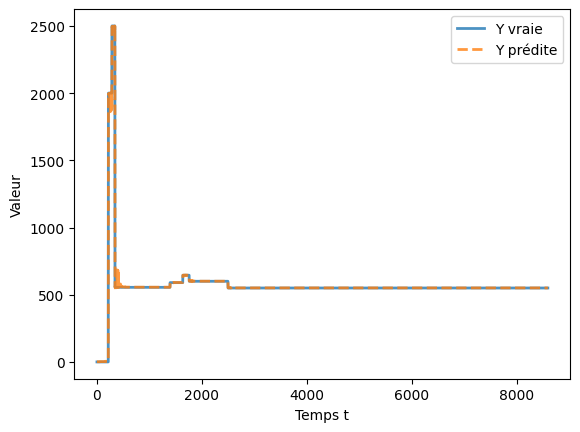

In [190]:
ml_utils.plot_pred_true(Y_train.reshape(T, N-S)[:, 10], Y_pred_train[:, 10])

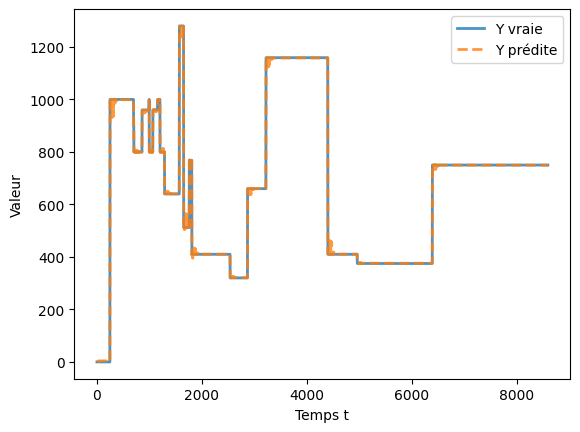

In [191]:
ml_utils.plot_pred_true(Y_test[:, 10], Y_pred_test[:, 10])

In [192]:
Y_pred_train_ar = ml_utils.auto_regressive_pred(model, X_train[..., :-h], h)
Y_pred_test_ar = ml_utils.auto_regressive_pred(model, X_test[..., :-h], h)

100%|██████████| 8588/8588 [00:06<00:00, 1415.29it/s]


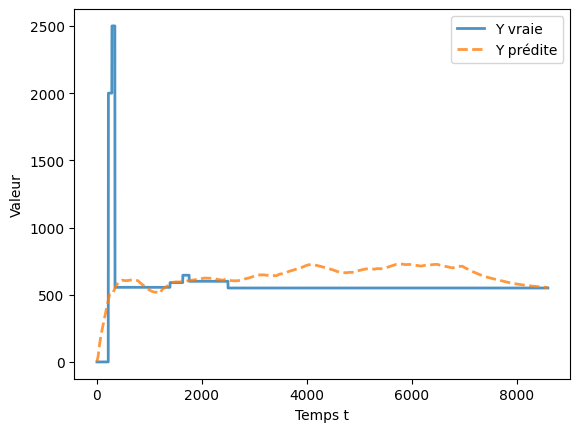

In [193]:
ml_utils.plot_pred_true(Y_train.reshape(T, N-S)[:, 10], Y_pred_test_ar[:, 10])

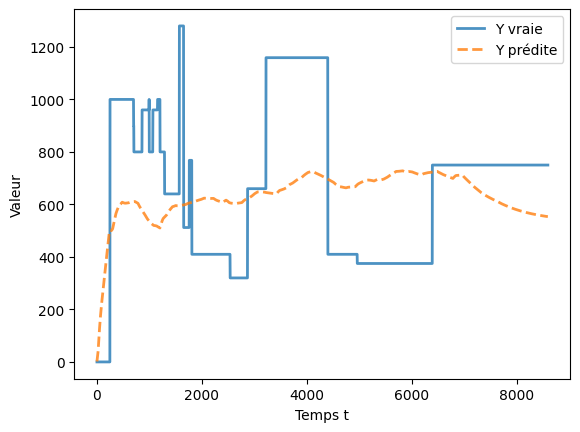

In [194]:
ml_utils.plot_pred_true(Y_test[:, 10], Y_pred_test_ar[:, 10])